In [1]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
import seaborn as sns
import shutil
from sklearn.utils.class_weight import compute_class_weight


In [2]:
import tensorflow as tf
print("TensorFlow device:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

TensorFlow device: GPU


In [3]:
zip_path = "Teeth DataSet.zip"
extract_path = "Teeth DataSet"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to:", extract_path)
print("Subfolders:", os.listdir(extract_path))


Extracted to: Teeth DataSet
Subfolders: ['Teeth_Dataset']


In [4]:
DATA_DIR = os.path.join(extract_path, "Teeth_Dataset")
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
VAL_DIR   = os.path.join(DATA_DIR, "Validation")
TEST_DIR  = os.path.join(DATA_DIR, "Testing")
print("Subfolders in data directory:", os.listdir(DATA_DIR))
print("TRAIN_DIR :", os.listdir(TRAIN_DIR))
print("VAL_DIR   :", os.listdir(VAL_DIR))
print("TEST_DIR  :", os.listdir(TEST_DIR))


Subfolders in data directory: ['Training', 'Testing', 'Validation']
TRAIN_DIR : ['CaS', 'OC', 'Gum', 'OT', 'MC', 'OLP', 'CoS']
VAL_DIR   : ['CaS', 'OC', 'Gum', 'OT', 'MC', 'OLP', 'CoS']
TEST_DIR  : ['CaS', 'OC', 'Gum', 'OT', 'outputs', 'MC', 'output', 'output_image.jpg', 'OLP', 'CoS', 'out']


In [5]:
TEST_DIR = os.path.join(DATA_DIR, "Testing")
extra_items = ["output_image.jpg", "out", "outputs","output"]
for item in extra_items:
    item_path = os.path.join(TEST_DIR, item)
    if os.path.exists(item_path):
        if os.path.isdir(item_path):
            shutil.rmtree(item_path)
            print(f"Removed folder: {item_path}")
        else:
            os.remove(item_path)
            print(f"Removed file: {item_path}")

print("Testing folder cleaned ")
print("Now TEST_DIR contains:", os.listdir(TEST_DIR))

Removed file: Teeth DataSet/Teeth_Dataset/Testing/output_image.jpg
Removed folder: Teeth DataSet/Teeth_Dataset/Testing/out
Removed folder: Teeth DataSet/Teeth_Dataset/Testing/outputs
Removed folder: Teeth DataSet/Teeth_Dataset/Testing/output
Testing folder cleaned 
Now TEST_DIR contains: ['CaS', 'OC', 'Gum', 'OT', 'MC', 'OLP', 'CoS']


In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_CLASSES = 7
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

Found 3087 files belonging to 7 classes.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)


Found 1028 files belonging to 7 classes.


In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

Found 1028 files belonging to 7 classes.


In [10]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


       CaS  CoS  Gum   MC   OC  OLP   OT
train  480  450  360  540  324  540  393
val    160  149  120  180  108  180  131
test   160  149  120  180  108  180  131


<Figure size 1000x400 with 0 Axes>

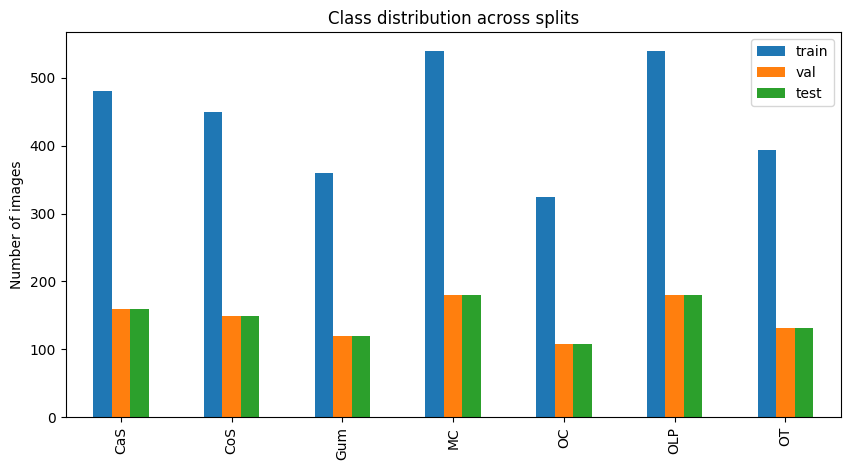

In [11]:
def dataset_class_distribution(ds):
    counts = {c:0 for c in class_names}
    for images, labels in ds.unbatch().map(lambda x,y:(x,y)).batch(10000):
        for l in labels.numpy():
            counts[class_names[int(l)]] += 1
    return counts

train_counts = dataset_class_distribution(train_ds)
val_counts = dataset_class_distribution(val_ds)
test_counts = dataset_class_distribution(test_ds)

dist_df = pd.DataFrame([train_counts, val_counts, test_counts], index=["train","val","test"])
print(dist_df)

plt.figure(figsize=(10,4))
dist_df.T.plot(kind='bar', stacked=False, figsize=(10,5))
plt.title("Class distribution across splits")
plt.ylabel("Number of images")
plt.show()

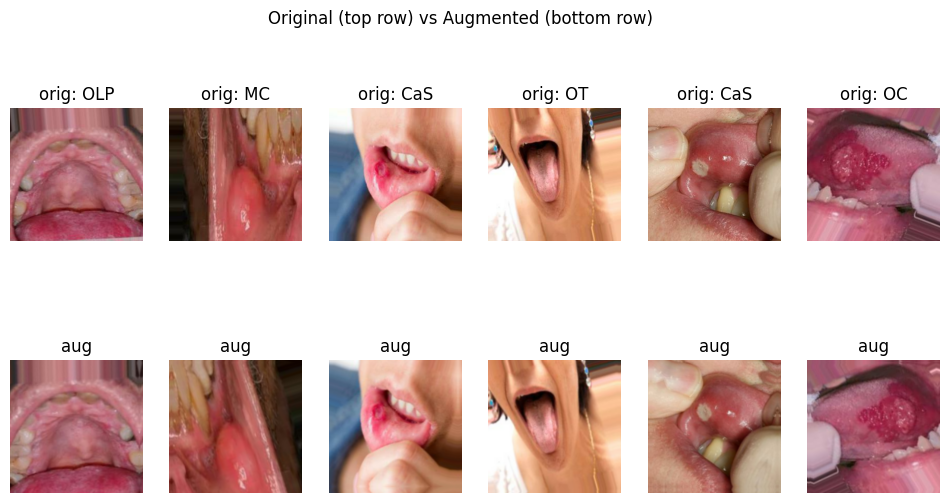

In [12]:
normalization_layer = layers.Rescaling(1./255)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.08),
        layers.RandomTranslation(0.05, 0.05),
    ],
    name="data_augmentation",
)

plt.figure(figsize=(12,6))
for images, labels in train_ds.take(1):
    images = images[:6]
    labels = labels[:6]
    for i in range(6):
        ax = plt.subplot(2,6, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(f"orig: {class_names[labels[i]]}")
        plt.axis("off")

    aug_images = data_augmentation(images)
    for i in range(6):
        ax = plt.subplot(2,6, 6+i+1)
        plt.imshow(aug_images[i].numpy().astype("uint8"))
        ax.set_title("aug")
        plt.axis("off")
plt.suptitle("Original (top row) vs Augmented (bottom row)")
plt.show()

In [13]:
train_ds = train_ds.map(lambda x,y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x,y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x,y: (normalization_layer(x), y))

train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [14]:
labels = np.concatenate([y for x, y in train_ds], axis=0)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.91875), 1: np.float64(0.98), 2: np.float64(1.225), 3: np.float64(0.8166666666666667), 4: np.float64(1.3611111111111112), 5: np.float64(0.8166666666666667), 6: np.float64(1.1221374045801527)}


In [15]:
def create_model(input_shape=IMG_SIZE+(3,), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)


    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="teeth_cnn")
    return model

model = create_model()
model.summary()

Model: "teeth_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           51

 Total params: 872,071 (3.33 MB)

 Trainable params: 870,471 (3.32 MB)

 Non-trainable params: 1,600 (6.25 KB)

In [16]:
model.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint_path = "teeth_model.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    #keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    #keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
]

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    verbose = 1,
    class_weight=class_weights
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.2949 - loss: 2.2510
Epoch 1: val_accuracy improved from -inf to 0.14494, saving model to teeth_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 85s 350ms/step - accuracy: 0.2960 - loss: 2.2451 - val_accuracy: 0.1449 - val_loss: 3.4688
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4603 - loss: 1.5012
Epoch 2: val_accuracy did not improve from 0.14494
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 140ms/step - accuracy: 0.4610 - loss: 1.4991 - val_accuracy: 0.1449 - val_loss: 6.6906
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5477 - loss: 1.2178
Epoch 3: val_accuracy did not improve from 0.14494
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 133ms/step - accuracy: 0.5478 - loss: 1.2179 - val_accuracy: 0.1449 - val_loss: 5.3954
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6000 - loss: 1.0547
Epoch 4: val_accuracy improved from 0.14494 to 0.15661, saving model to teeth_model.keras
49/49 ━━━━━━━━━━━━━━━━━

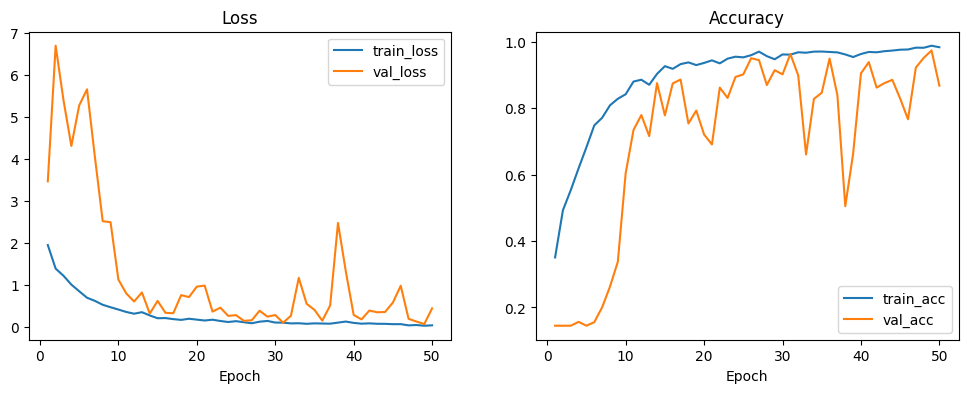

In [18]:
def plot_history(history):
    h = history.history
    epochs = range(1, len(h['loss'])+1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h['loss'], label='train_loss')
    plt.plot(epochs, h['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1,2,2)
    plt.plot(epochs, h['accuracy'], label='train_acc')
    plt.plot(epochs, h['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

plot_history(history)

In [19]:
test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7901 - loss: 0.7770
Test accuracy: [0.48892223834991455, 0.8550583720207214]


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
Classification Report:
              precision    recall  f1-score   support

         CaS       0.94      0.99      0.96       160
         CoS       0.99      0.97      0.98       149
         Gum       0.95      0.97      0.96       120
          MC       0.96      0.96      0.96       180
          OC       0.96      0.93      0.94       108
     

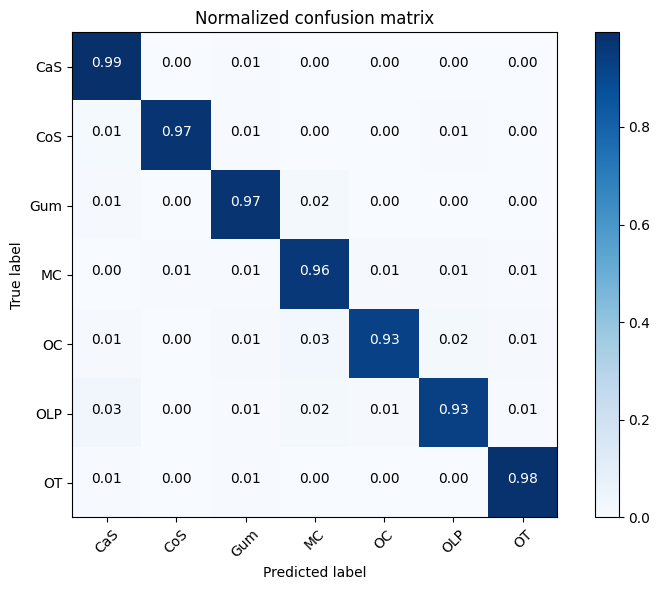

In [20]:
model.load_weights(checkpoint_path)

y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8,6))
    if normalize:
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cmn = cm
    plt.imshow(cmn, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cmn.max() / 2.
    for i, j in itertools.product(range(cmn.shape[0]), range(cmn.shape[1])):
        plt.text(j, i, format(cmn[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cmn[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, class_names, normalize=True, title='Normalized confusion matrix')

In [21]:
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0 , DenseNet121 , InceptionV3

models_dict = {
    "ResNet50": ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)),
    "VGG16": VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3)),
    "DenseNet121": DenseNet121(weights="imagenet", include_top=False, input_shape=(224,224,3)),
    "InceptionV3": InceptionV3(weights="imagenet", include_top=False,input_shape=(224,224,3))
    #"EfficientNetB0": EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3)),

}

history_dict = {}
accuracy_scores = {}



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [22]:
def plot_history(history, model_name):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label="train acc")
    plt.plot(history.history['val_accuracy'], label="val acc")
    plt.title(f"{model_name} Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="train loss")
    plt.plot(history.history['val_loss'], label="val loss")
    plt.title(f"{model_name} Loss")
    plt.legend()

    plt.show()

In [23]:
def build_model(base_model, num_classes):
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    return model



Model Summary for ResNet50:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 90s 505ms/step - accuracy: 0.1531 - loss: 2.0065 - val_accuracy: 0.1877 - val_loss: 1.9248
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 197ms/step - accuracy: 0.1624 - loss: 1.9441 - val_accuracy: 0.1751 - val_loss: 1.9330
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 83s 200ms/step - accuracy: 0.1997 - loss: 1.9093 - val_accuracy: 0.2023 - val_loss: 1.8857
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 196ms/step - accuracy: 0.2188 - loss: 1.8918 - val_accuracy: 0.2033 - val_loss: 1.9065
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 196ms/step - accuracy: 0.2350 - loss: 1.8868 - val_accuracy: 0.2840 - val_loss: 1.8646
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 197ms/step - accuracy: 0.2307 - loss: 1.8722 - val_accuracy: 0.2772 - val_loss: 1.8423
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 201ms/step - accuracy: 0.2488 - loss: 1.8538 - val_accuracy: 0.2198 - val_loss: 1.8519
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 83s 200ms/step - accuracy: 0.2482 - loss: 1.8368 - val_accu

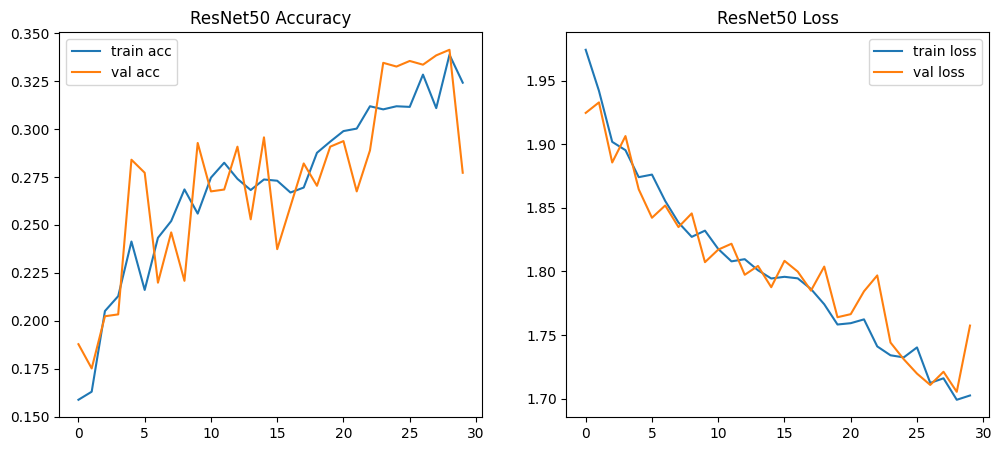


Model Summary for VGG16:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,255 (56.39 MB)

 Trainable params: 66,567 (260.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 105s 624ms/step - accuracy: 0.2339 - loss: 1.8802 - val_accuracy: 0.3745 - val_loss: 1.6463
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 70s 382ms/step - accuracy: 0.3922 - loss: 1.6049 - val_accuracy: 0.4805 - val_loss: 1.4735
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 381ms/step - accuracy: 0.4771 - loss: 1.4663 - val_accuracy: 0.5175 - val_loss: 1.3840
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 70s 385ms/step - accuracy: 0.5080 - loss: 1.3737 - val_accuracy: 0.5389 - val_loss: 1.3255
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 378ms/step - accuracy: 0.5310 - loss: 1.3028 - val_accuracy: 0.5700 - val_loss: 1.2557
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 376ms/step - accuracy: 0.5513 - loss: 1.2637 - val_accuracy: 0.5973 - val_loss: 1.1864
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 83s 379ms/step - accuracy: 0.5769 - loss: 1.2010 - val_accuracy: 0.5982 - val_loss: 1.1872
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 385ms/step - accuracy: 0.6002 - loss: 1.1613 - val_acc

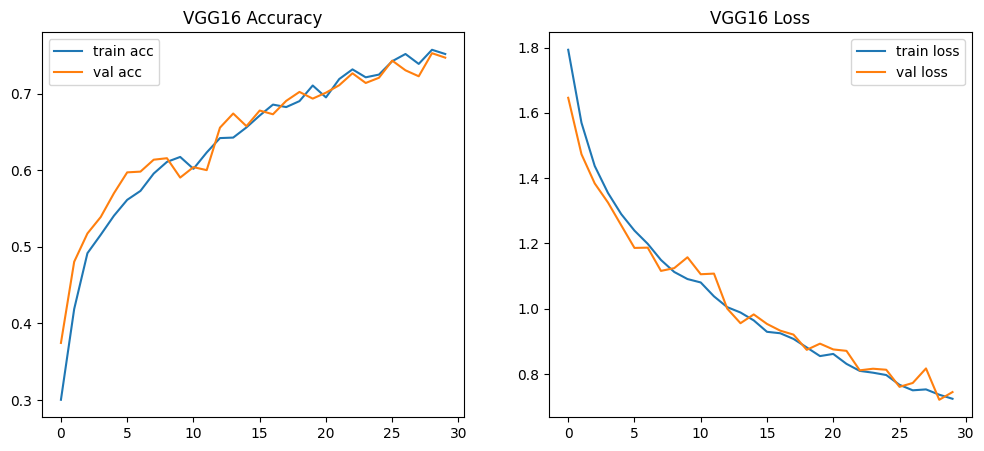


Model Summary for DenseNet121:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169,607 (27.35 MB)

 Trainable params: 132,103 (516.03 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.3546 - loss: 1.7077 - val_accuracy: 0.6362 - val_loss: 1.0564
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 68s 190ms/step - accuracy: 0.6376 - loss: 1.0100 - val_accuracy: 0.6634 - val_loss: 0.9270
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 191ms/step - accuracy: 0.7081 - loss: 0.8392 - val_accuracy: 0.7335 - val_loss: 0.7472
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.7515 - loss: 0.7275 - val_accuracy: 0.7792 - val_loss: 0.6416
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 84s 183ms/step - accuracy: 0.7820 - loss: 0.6361 - val_accuracy: 0.7879 - val_loss: 0.6308
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 80s 191ms/step - accuracy: 0.8075 - loss: 0.5786 - val_accuracy: 0.8191 - val_loss: 0.5293
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 183ms/step - accuracy: 0.8386 - loss: 0.4917 - val_accuracy: 0.8171 - val_loss: 0.5387
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 182ms/step - accuracy: 0.8462 - loss: 0.4694 - val_accura

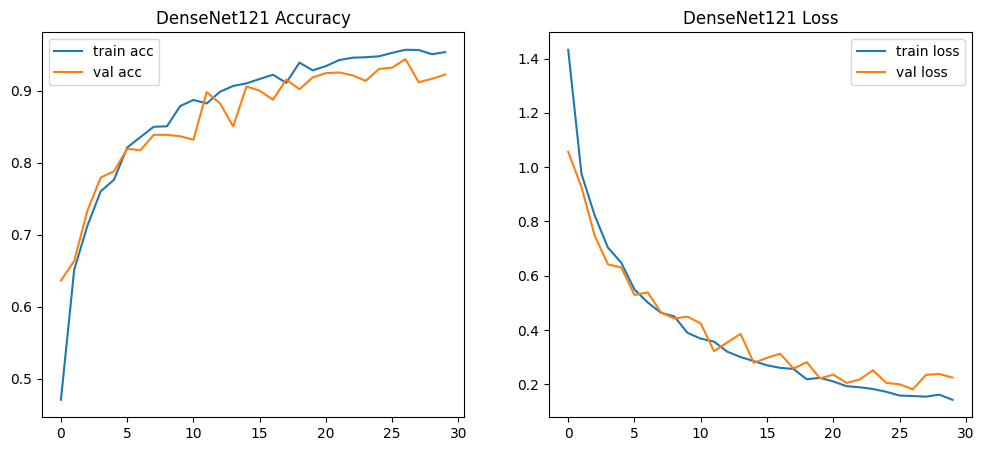


Model Summary for InceptionV3:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,959 (84.17 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 108s 793ms/step - accuracy: 0.3672 - loss: 1.7114 - val_accuracy: 0.6031 - val_loss: 1.0722
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 100s 155ms/step - accuracy: 0.6041 - loss: 1.0373 - val_accuracy: 0.6041 - val_loss: 1.0039
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 156ms/step - accuracy: 0.6817 - loss: 0.8545 - val_accuracy: 0.7121 - val_loss: 0.7900
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 154ms/step - accuracy: 0.7315 - loss: 0.7471 - val_accuracy: 0.7062 - val_loss: 0.7880
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - accuracy: 0.7594 - loss: 0.6670 - val_accuracy: 0.7432 - val_loss: 0.6511
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 156ms/step - accuracy: 0.7836 - loss: 0.6139 - val_accuracy: 0.7519 - val_loss: 0.6449
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 171ms/step - accuracy: 0.8046 - loss: 0.5563 - val_accuracy: 0.7743 - val_loss: 0.5975
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 58s 157ms/step - accuracy: 0.8155 - loss: 0.5165 - val_ac

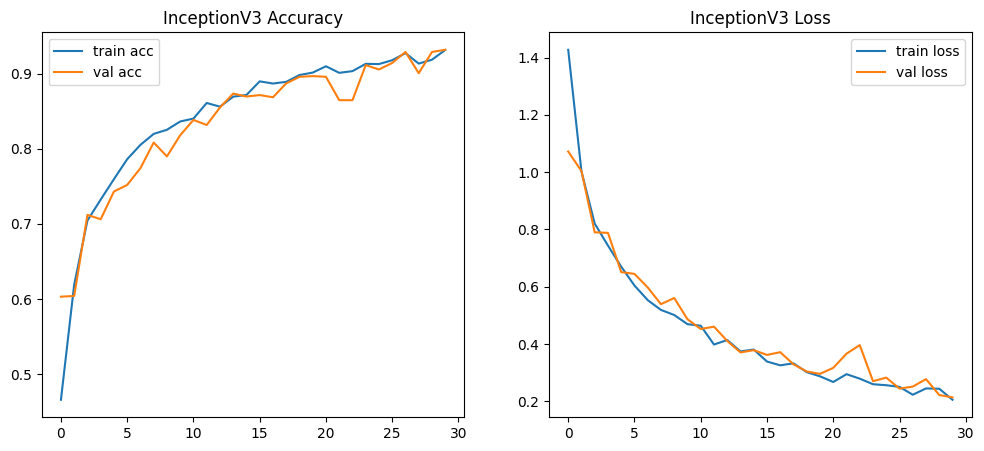

In [24]:
for name, base_model in models_dict.items():
    model2 = build_model(base_model, NUM_CLASSES)

    print(f"\nModel Summary for {name}:")
    model2.summary()


    model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    history2 = model2.fit(train_ds, validation_data=val_ds, epochs=30, verbose=1)

    test_loss, test_acc = model2.evaluate(test_ds, verbose=0)
    print(f"{name} Test Accuracy: {test_acc:.4f}")

    history_dict[name] = history2
    accuracy_scores[name] = (model2, test_acc)


    plot_history(history2, name)




17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 532ms/step

Classification Report for ResNet50:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       160
           1       0.96      0.99      0.98       149
           2       0.92      0.94      0.93       120
           3       0.95      0.93      0.94       180
           4       0.91      0.92      0.91       108
           5       0.96      0.88      0.92       180
           6       0.88      0.98      0.93       131

    accuracy                           0.94      1028
   macro avg       0.94      0.94      0.94      1028
weighted avg       0.94      0.94      0.94      1028



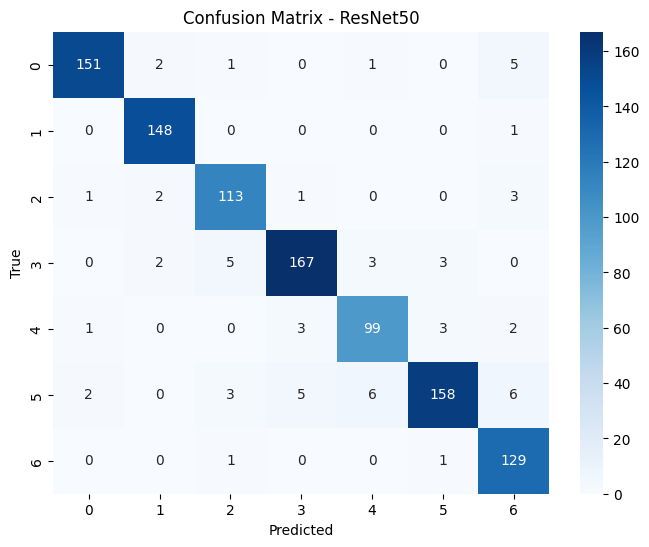

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step

Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       160
           1       0.96      0.99      0.98       149
           2       0.92      0.94      0.93       120
           3       0.95      0.93      0.94       180
           4       0.91      0.92      0.91       108
           5       0.96      0.88      0.92       180
           6       0.88      0.98      0.93       131

    accuracy                           0.94      1028
   macro avg       0.94      0.94      0.94      1028
weighted avg       0.94      0.94      0.94      1028



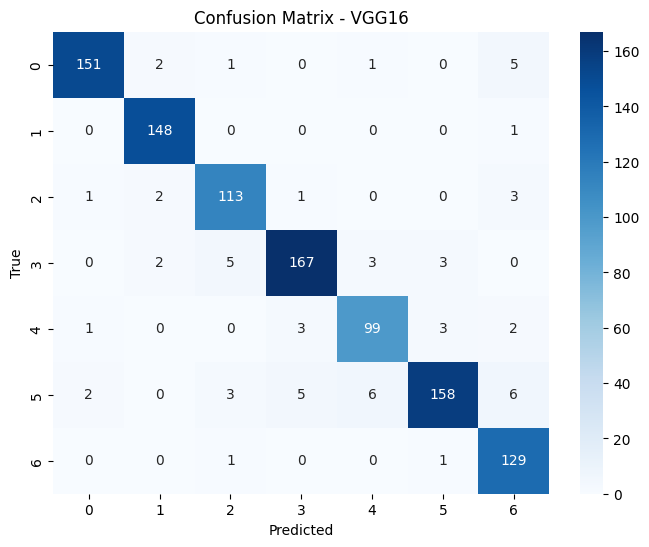

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step

Classification Report for DenseNet121:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       160
           1       0.96      0.99      0.98       149
           2       0.92      0.94      0.93       120
           3       0.95      0.93      0.94       180
           4       0.91      0.92      0.91       108
           5       0.96      0.88      0.92       180
           6       0.88      0.98      0.93       131

    accuracy                           0.94      1028
   macro avg       0.94      0.94      0.94      1028
weighted avg       0.94      0.94      0.94      1028



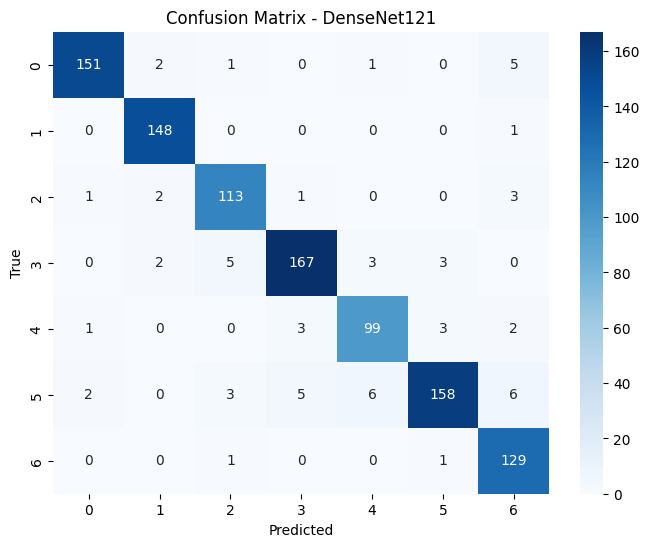

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step

Classification Report for InceptionV3:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       160
           1       0.96      0.99      0.98       149
           2       0.92      0.94      0.93       120
           3       0.95      0.93      0.94       180
           4       0.91      0.92      0.91       108
           5       0.96      0.88      0.92       180
           6       0.88      0.98      0.93       131

    accuracy                           0.94      1028
   macro avg       0.94      0.94      0.94      1028
weighted avg       0.94      0.94      0.94      1028



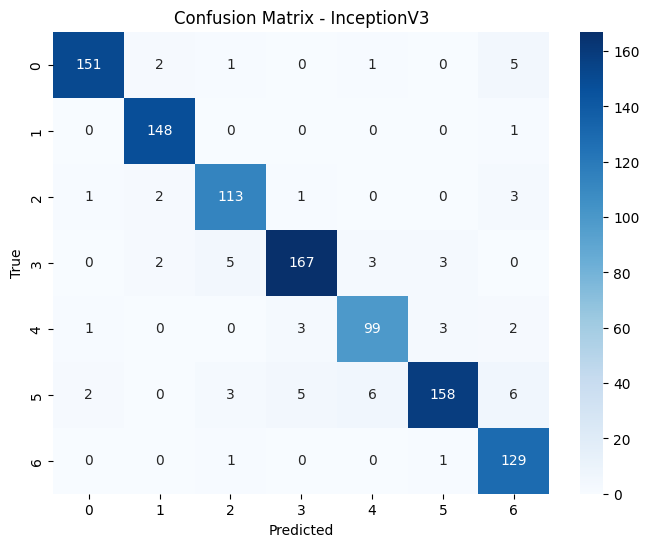

In [25]:
for name, base_model in models_dict.items():
    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    y_pred = model2.predict(test_ds)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(f"\nClassification Report for {name}:")
    print(classification_report(y_true, y_pred_classes))

    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [26]:
for k, v in list(accuracy_scores.items()):
    if not isinstance(v, tuple):
        accuracy_scores[k] = (None, v)


In [27]:
print(accuracy_scores)

{'ResNet50': (<Functional name=functional_1, built=True>, 0.29571983218193054), 'VGG16': (<Functional name=functional_2, built=True>, 0.7422178983688354), 'DenseNet121': (<Functional name=functional_3, built=True>, 0.9309338331222534), 'InceptionV3': (<Functional name=functional_4, built=True>, 0.938715934753418)}


In [28]:
import os
os.makedirs("saved_models", exist_ok=True)

best_model_name = max(accuracy_scores , key=lambda k: accuracy_scores [k][1])
best_model, best_acc = accuracy_scores  [best_model_name]

save_path = f"saved_models/{best_model_name}_best.keras"
best_model.save(save_path)

print(f"Best model ({best_model_name}) saved at {save_path} with accuracy {best_acc:.4f}")


Best model (InceptionV3) saved at saved_models/InceptionV3_best.keras with accuracy 0.9387
